# Text Clustering and Topic Modeling

Data: **BBC Sport data** - the data set consits of 737 documents from the BBC Sport website and corresponds to sport news articles from 2004-2005 in five topics:
- athletics
- cricket
- football 
- rugby 
- tennis

In [1]:
from sklearn.datasets import load_files
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from sklearn import metrics

from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
random_state = 321 
#The random_state parameter ensures that the data is shuffled in a reproducible way if it's set to a fixed number.

DATA_DIR = "/Users/davidebonaglia/Dropbox/PhD NOTES/COURSES/Utretch Summer School/Tuesday/bbcsport-fulltext/bbcsport"
data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace", random_state=random_state)
df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
df

,text,label
0,"Scotland v Italy (Sat)\n\nMurrayfield, Edinbur...",3
1,Wales silent on Grand Slam talk\n\nRhys Willia...,3
2,Arsenal 1-1 Sheff Utd\n\nAndy Gray's 90th-minu...,2
3,Cole refuses to blame van Persie\n\nAshley Col...,2
4,Van Nistelrooy hungry for return\n\nManchester...,2
...,...,...
732,England claim historic series win\n\nFifth Tes...,1
733,Henry tipped for Fifa award\n\nFifa president ...,2
734,Philippoussis doubt over Open bid\n\nMark Phil...,4
735,India's top six secure - Ganguly\n\nCaptain So...,1


In [3]:
labels, counts = np.unique(df['label'], return_counts=True)
print(dict(zip(data.target_names, counts)))

{'athletics': 101, 'cricket': 124, 'football': 265, 'rugby': 147, 'tennis': 100}


In [4]:
data.target_names

['athletics', 'cricket', 'football', 'rugby', 'tennis']

For text clustering and topic modeling, we will ignore the labels but we will use them while evaluating models. 
We will create a copied dataframe removing the outcome variable.

In [5]:
bbcsport_text = pd.DataFrame(df['text'])
bbcsport_text.head()

,text
0,"Scotland v Italy (Sat)\n\nMurrayfield, Edinbur..."
1,Wales silent on Grand Slam talk\n\nRhys Willia...
2,Arsenal 1-1 Sheff Utd\n\nAndy Gray's 90th-minu...
3,Cole refuses to blame van Persie\n\nAshley Col...
4,Van Nistelrooy hungry for return\n\nManchester...


We will apply the following pre-processing steps:
- convert to lower
- remove stop words
- remove numbers
- extract uni- and bi-grams
- remove terms that occur in less than 2 documents
- remove one-letter terms, e.g.'a', or 's'

And then convert the data to a dataframe of document-term matrix with term frequencies

In [6]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   lowercase=True,
                                   min_df=2,
                                   ngram_range=(1,2), 
                                   token_pattern=r'(?u)\b[A-Za-z][A-Za-z]+\b')
tfidf_vectorizer.fit(df.text.values)
tfidf_matrix = tfidf_vectorizer.transform(df.text.values)
tfidf_matrix.shape

(737, 21604)

In [7]:
tfidf_vectorizer.vocabulary_

{'scotland': 16588,
 'italy': 9554,
 'sat': 16416,
 'murrayfield': 12483,
 'edinburgh': 5500,
 'saturday': 16420,
 'february': 6375,
 'gmt': 7592,
 'live': 10930,
 'website': 20649,
 'victory': 20246,
 'azzurri': 1162,
 'rome': 15819,
 'year': 21407,
 'saw': 16453,
 'end': 5635,
 'campaign': 2428,
 'pressure': 14463,
 'coach': 3334,
 'matt': 11818,
 'williams': 20857,
 'seeks': 16838,
 'nations': 12557,
 'eighth': 5541,
 'attempt': 990,
 'lost': 11181,
 'opening': 13151,
 'games': 7288,
 'home': 8678,
 'ireland': 9450,
 'wales': 20390,
 'travel': 19657,
 'high': 8536,
 'hopes': 8748,
 'john': 9743,
 'kirwan': 10230,
 'warned': 20519,
 'errors': 5894,
 'blighted': 1816,
 'loss': 11173,
 'risk': 15689,
 'suffering': 18370,
 'successive': 18351,
 'defeat': 4554,
 'taught': 18702,
 'level': 10734,
 'make': 11412,
 'mistakes': 12256,
 'said': 16105,
 'error': 5893,
 'come': 3435,
 'price': 14500,
 'aggressive': 313,
 'minutes': 12165,
 'calm': 2377,
 'situation': 17385,
 'display': 5042,
 '

## K-Means clustering

Since the data set contains articles that belong to one of the 5 categories, we set the number of clusters at 5

In [8]:
n_clusters = 5
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state)
cls.fit(tfidf_matrix)

MiniBatchKMeans(n_clusters=5, random_state=321)

### top terms in each cluster

In [9]:
print("Top terms per cluster:")

order_centroids = cls.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s/' % terms[ind], end='')
    print()

#https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

Top terms per cluster:
Cluster 0: cricket/ pakistan/ series/ australia/ test/ india/ sri/ day/ zealand/ new zealand/
Cluster 1: england/ south/ vaughan/ south africa/ africa/ test/ strauss/ jones/ overs/ day/
Cluster 2: said/ chelsea/ club/ united/ arsenal/ game/ league/ cup/ liverpool/ players/
Cluster 3: olympic/ indoor/ holmes/ race/ world/ champion/ athletics/ athens/ european/ marathon/
Cluster 4: england/ wales/ ireland/ rugby/ france/ nations/ robinson/ half/ scotland/ coach/


### Graphically visualizing the output

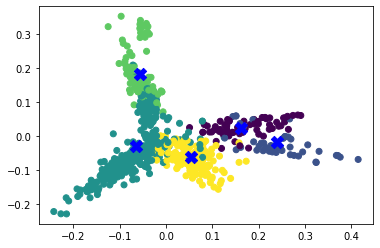

In [10]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(tfidf_matrix))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='X', s=150, c='b')

### Evaluation of K-Means clustering

We will evaluate the quality of the K-Means clustering with the sklearn metrics for clustering: 
- homogeneity_score, 
- completeness_score, 
- v_measure_score, 
- adjusted_rand_score, 
- silhouette_score.

In [11]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(data.target, cls.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(data.target, cls.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(data.target, cls.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(data.target, cls.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(tfidf_matrix, cls.labels_, sample_size=1000))

Homogeneity: 0.668
Completeness: 0.784
V-measure: 0.722
Adjusted Rand-Index: 0.600
Silhouette Coefficient: 0.014


### Expand nuber of clusters

We will apply the K-Means clustering method on a range of 3 to 7 clusters, and calculate the squared loss obtained in each clustering. Apply the Elbow method to find the optimal k.

In [12]:
num_clus = [x for x in range(3, 7)]
squared_errors = []

for cluster in num_clus:
    cls = MiniBatchKMeans(n_clusters=cluster, random_state=random_state)
    
    # Train Clusters
    cls.fit(tfidf_matrix) 
    
    # Appending the squared loss obtained in the list
    squared_errors.append(cls.inertia_) 

We can choose the best cluster with the **Elbow Method**: https://www.kaggle.com/karthik3890/text-clustering

The Elbow Method is a graphical representation of finding the optimal k in a K-means clustering. It works by finding WCSS (Within-Cluster Sum of Square) i.e. the sum of the square distance between points in a cluster and the cluster centroid.

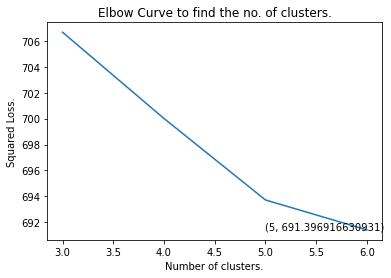

The optimal number of clusters obtained is -  5
The loss for optimal cluster is -  691.396916630931


In [13]:
optimal_clusters = np.argmin(squared_errors) + 2 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve to find the no. of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

Use the following two news articles as your test data, and predict cluster labels for your new data set with the best value for K and the K-Means algorithm.

In [14]:
documents = ['Frank de Boer out as Oranje manager after early Euro 2020 exit Dutch men’s football team coach.',
             'The time has come for Nadal to be selective in the events that he should and should not play. This is where he can start the difficulty. After a rigorous participation of the clay season, Rafael Nadal definitely wants to conserve his energies for as long as possible.']

In [15]:
n_clusters = 5
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state)
cls.fit(tfidf_matrix)

MiniBatchKMeans(n_clusters=5, random_state=321)

In [16]:
tfidf_test = tfidf_vectorizer.transform(documents)
tfidf_test.shape

(2, 21604)

In [19]:
print(cls.predict(tfidf_test))

#they both belong to cluster number 2 (even though the second text is about tennis)

[2 2]


## Hierarchical clustering

Hierarchical clustering is a type of unsupervised machine learning algorithm used to cluster unlabeled data points. 

Similar to the K-Means clustering, hierarchical clustering groups together the data points with similar characteristics. 

Fit the model with 5 clusters and check the predicted labels.

In [17]:
# affinity='euclidean'
cls2 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward') 

cls2 = cls2.fit(tfidf_matrix.toarray())

In [18]:
cls2.labels_

array([4, 4, 2, 2, 2, 4, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 4, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 4, 1, 0, 2, 2, 2, 0, 2,
       2, 1, 2, 2, 4, 0, 1, 0, 4, 2, 2, 1, 2, 1, 0, 2, 4, 0, 0, 0, 1, 2,
       2, 0, 0, 2, 1, 4, 2, 2, 0, 1, 2, 2, 0, 4, 4, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 0, 0, 1, 0, 2, 3, 4, 0, 1, 4, 2, 0, 0, 4, 2, 2, 4, 4, 2, 2,
       1, 0, 4, 4, 2, 0, 0, 0, 2, 4, 1, 2, 2, 1, 4, 2, 2, 2, 0, 0, 1, 1,
       4, 4, 2, 1, 2, 2, 0, 0, 2, 3, 2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 2, 0,
       4, 2, 1, 2, 4, 2, 2, 2, 2, 4, 2, 4, 0, 0, 4, 2, 2, 2, 1, 2, 1, 1,
       2, 2, 2, 2, 2, 0, 4, 0, 4, 1, 1, 0, 0, 4, 2, 2, 1, 1, 4, 2, 1, 2,
       2, 0, 4, 2, 0, 2, 4, 4, 1, 0, 1, 2, 1, 0, 0, 0, 0, 2, 4, 3, 2, 2,
       0, 4, 1, 1, 1, 2, 2, 1, 1, 4, 1, 4, 2, 1, 2, 2, 2, 1, 4, 1, 2, 2,
       2, 2, 2, 4, 2, 0, 1, 4, 4, 1, 0, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 0, 2, 4, 2, 2, 2, 1, 4, 1, 0, 2, 4, 0, 2, 1, 0,
       0, 0, 4, 2, 2, 0, 2, 0, 0, 2, 4, 2, 0, 0, 4,

Plot endrogram for the hierarchical clustering

In [19]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

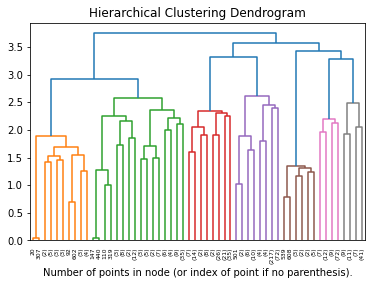

In [20]:
# setting distance_threshold=0 ensures we compute the full tree.
cls2 = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward', distance_threshold=0)
cls2 = cls2.fit(tfidf_matrix.toarray())

plt.title('Hierarchical Clustering Dendrogram')

# plot the top three levels of the dendrogram
plot_dendrogram(cls2, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

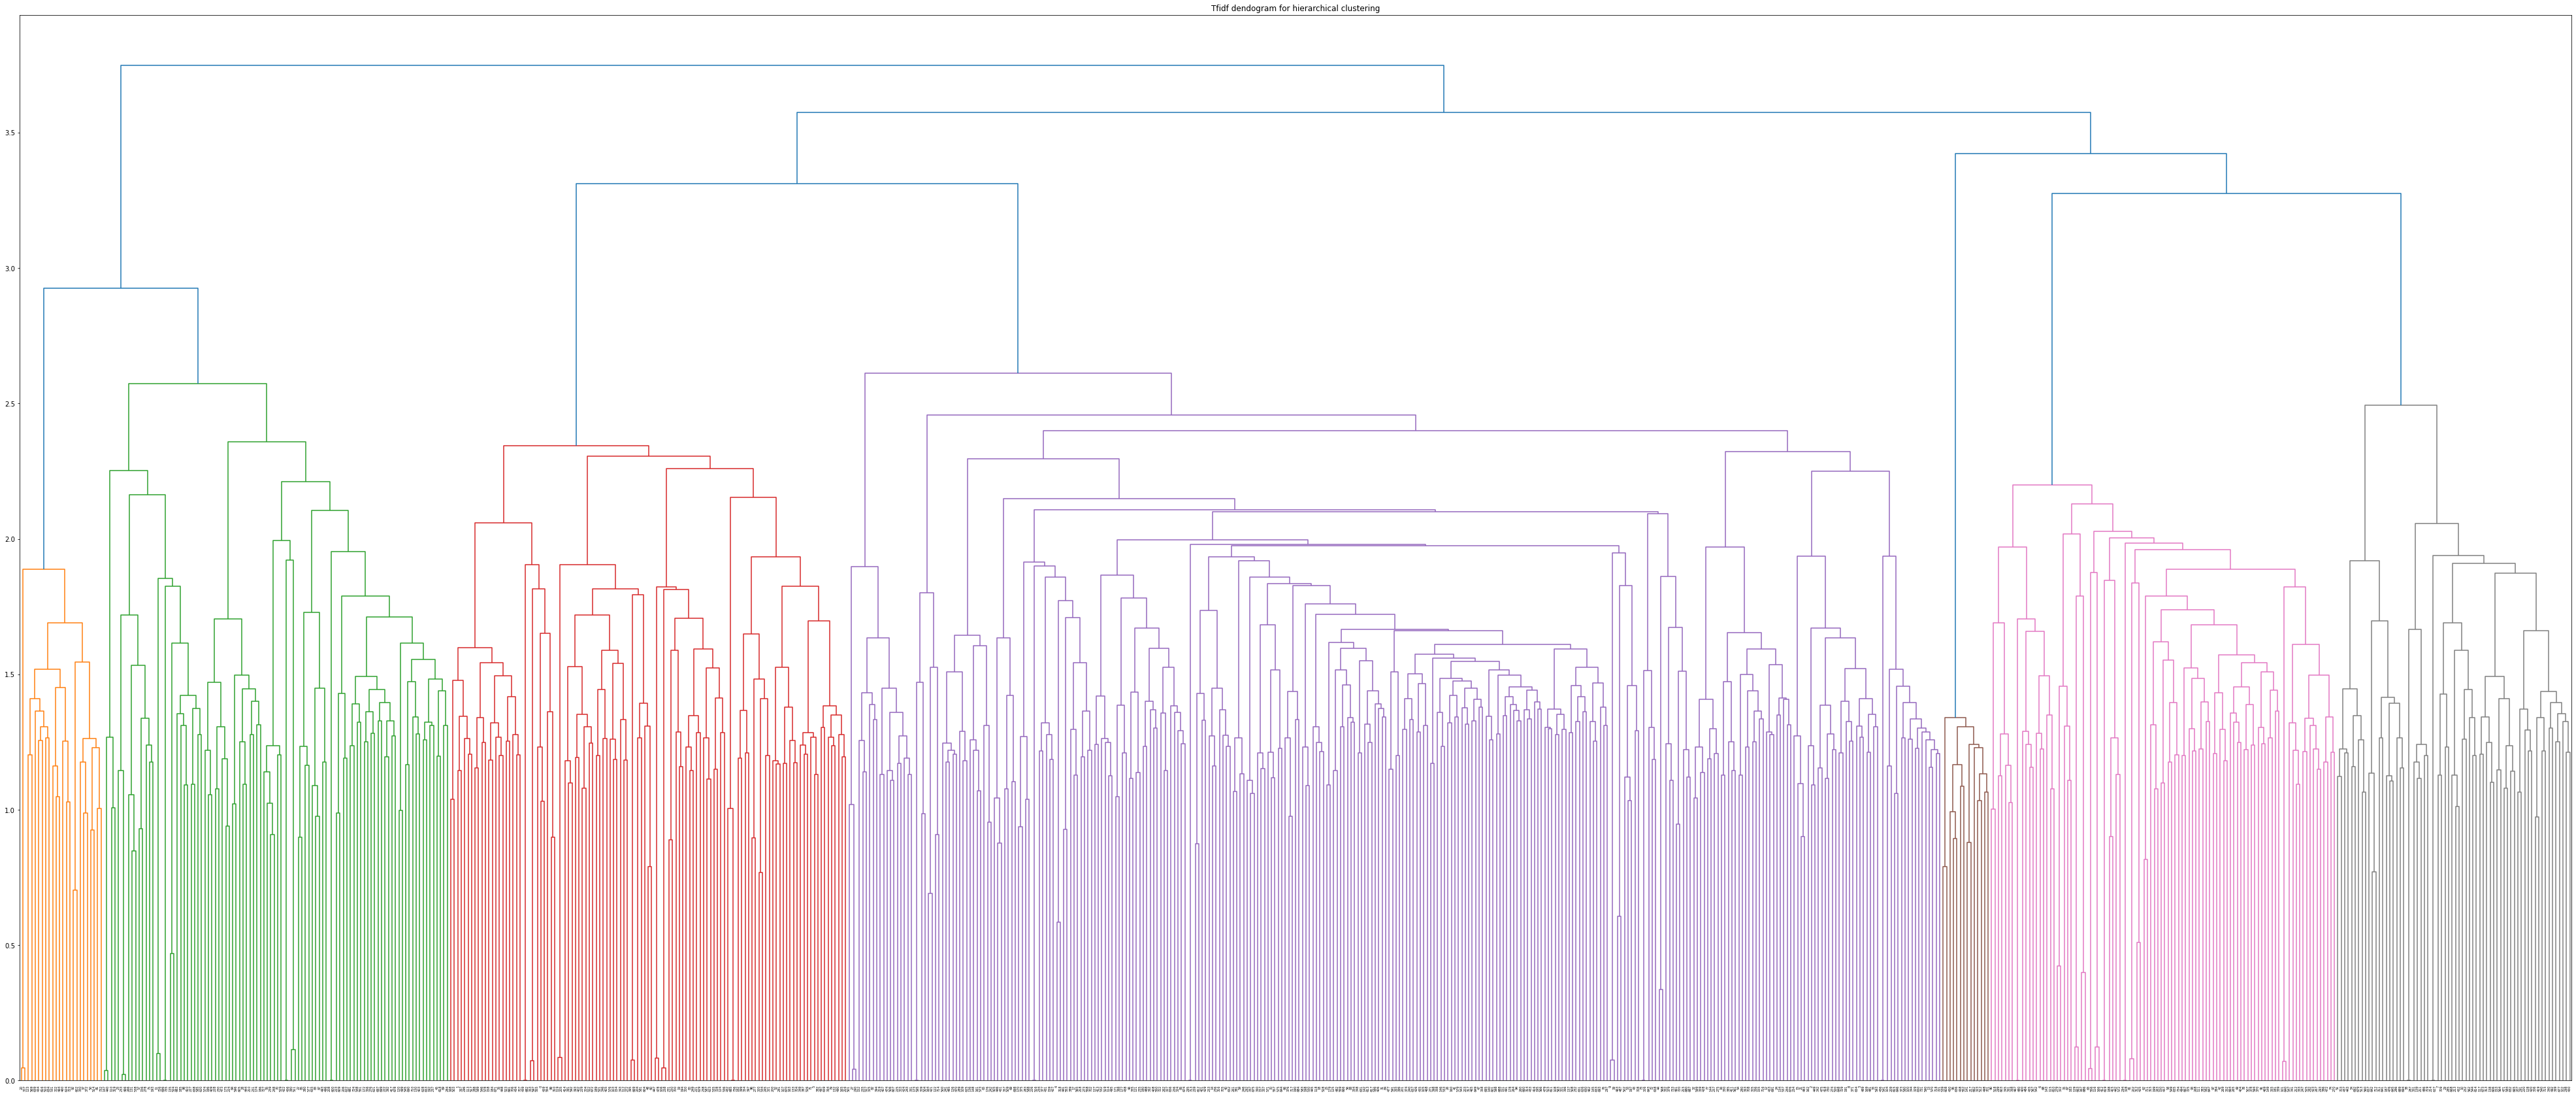

In [26]:
# here is another way of plotting the hc using the scipy library 

import scipy.cluster.hierarchy as shc

plt.figure(figsize=(70, 30))
plt.title("Tfidf dendogram for hierarchical clustering")
dend = shc.dendrogram(shc.linkage(tfidf_matrix.toarray(), method='ward'))

## Topic modeling

Topic modeling is another unsupervised method for text mining applications where we want to get an idea of what topics we have in our data set. **A topic is a collection of words that describe the overall theme**.

For example, in case of news articles, you might think of topics as the categories in the data set. 
Just like clustering algorithms, there are some algorithms that need you to specify the number of topics you want to extract from the data set and some that automatically determine the number of topics. 

Here, we will be using the Non-Negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) methods for topic modeling. 

### NMF model

In [27]:
# number of topics to extract
n_topics = 5

nmf = NMF(n_components=n_topics, random_state=random_state)
nmf.fit(tfidf_matrix)

NMF(n_components=5, random_state=321)

Top 10 words per topic with their probabilities

In [28]:
for i, topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['champions league', 'cup', 'said', 'mourinho', 'club', 'liverpool', 'united', 'league', 'arsenal', 'chelsea']


Top 10 words for topic #1:
['england', 'africa', 'india', 'south africa', 'day', 'south', 'series', 'pakistan', 'cricket', 'test']


Top 10 words for topic #2:
['olympic', 'final', 'seed', 'set', 'race', 'indoor', 'year', 'champion', 'open', 'world']


Top 10 words for topic #3:
['game', 'scotland', 'half', 'nations', 'france', 'rugby', 'robinson', 'ireland', 'wales', 'england']


Top 10 words for topic #4:
['charges', 'athletics', 'olympics', 'doping', 'athens', 'drugs', 'iaaf', 'thanou', 'greek', 'kenteris']




Now, we will use the NMF model to identify the topic (or cluster) of a the new texts in the documents object. 
We then choose the topic with the highest score to determine documents' topics


first transform the text into features using tfidf_vectorizer then pass it to transform of nmf
the result will be a matrix of shape [2, 10] then we sort the topic id based on the score using argsort
and take the last one (with the highest score) for each row using `[:,-1]` indexing

In [29]:
print(nmf.transform(tfidf_vectorizer.transform(documents)))
nmf.transform(tfidf_vectorizer.transform(documents)).argsort(axis=1)[:,-1]

[[0.03102346 0.00036267 0.01099815 0.00809537 0.00311989]
 [0.01549877 0.00264124 0.03429618 0.00092925 0.        ]]


array([0, 2])

First documnt belongs to topic 0: football
Second document belongs to topic2 : tennis

**That's better than before**

### LDA Model

The LDA is based upon two general assumptions:
- Documents exhibit multiple topics
- A topic is a distribution over a fixed vocabulary


We will train a LDA model from the sklearn package for topic modeling with 5 components

In [30]:
LDA = LatentDirichletAllocation(n_components=5, random_state=321, evaluate_every=10)
LDA.fit(tfidf_matrix)

LatentDirichletAllocation(evaluate_every=10, n_components=5, random_state=321)

In [31]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['play', 'cup', 'players', 'team', 'win', 'world', 'year', 'game', 'england', 'said']


Top 10 words for topic #1:
['maurice', 'holmes', 'capriati', 'mauresmo', 'isinbayeva', 'sharapova', 'greene', 'lewis francis', 'francis', 'mirza']


Top 10 words for topic #2:
['gregory lamboley', 'imanol', 'half replacement', 'valbon', 'harinordoquy', 'stade', 'bortolami', 'bourgoin', 'toulousain', 'stade toulousain']


Top 10 words for topic #3:
['tribunal', 'charges', 'balco', 'conte', 'drugs', 'doping', 'thanou', 'greek', 'iaaf', 'kenteris']


Top 10 words for topic #4:
['money women', 'rod', 'aus', 'ind', 'pattaya', 'prize money', 'kafer', 'martinez', 'umaga', 'hingis']




In [32]:
# We can also use the following function for this purpose:

def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


no_top_words = 10
display_topics(LDA, tfidf_vectorizer.get_feature_names(), no_top_words=no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,said,21.1,mirza,2.2,stade toulousain,1.0,kenteris,3.5,hingis,1.0
1,england,18.2,francis,2.0,toulousain,1.0,iaaf,3.1,umaga,1.0
2,game,13.8,lewis francis,2.0,bourgoin,0.6,greek,3.1,martinez,0.9
3,year,13.6,greene,1.7,bortolami,0.6,thanou,3.1,kafer,0.8
4,world,12.6,sharapova,1.3,stade,0.6,doping,2.5,prize money,0.7
5,win,12.3,isinbayeva,1.2,harinordoquy,0.6,drugs,2.3,pattaya,0.7
6,team,11.9,mauresmo,1.0,valbon,0.5,conte,2.2,ind,0.7
7,players,11.5,capriati,1.0,half replacement,0.4,balco,1.8,aus,0.7
8,cup,11.4,holmes,1.0,imanol,0.4,charges,1.5,rod,0.6
9,play,11.4,maurice,1.0,gregory lamboley,0.4,tribunal,1.4,money women,0.6


Transform the learned topics into your data

In [33]:
topic_values = LDA.transform(tfidf_matrix)
topic_values.shape

(737, 5)

In [34]:
topic_values

array([[0.95297704, 0.01175449, 0.01175873, 0.01175444, 0.01175529],
       [0.94455696, 0.01385469, 0.01387983, 0.0138542 , 0.01385432],
       [0.94949035, 0.01264149, 0.01261802, 0.01263226, 0.01261788],
       ...,
       [0.92571628, 0.01857336, 0.01856985, 0.01857083, 0.01856967],
       [0.4823713 , 0.48677254, 0.01028672, 0.01028405, 0.0102854 ],
       [0.363303  , 0.01191515, 0.60094594, 0.01191983, 0.01191608]])

Finally, we will use the score function for LDA to calculate the log likelihood for your data, and compare two LDA models with 5 and 10 topics.

Many procedures use the log of the likelihood, rather than the likelihood itself, because it is easier to work with. The log likelihood (i.e., the log of the likelihood) will always be negative, with **higher values** (closer to zero) **indicating a better fitting model**

The best fit in this case is the model with **5 topics**

In [36]:
LDA10 = LatentDirichletAllocation(n_components=10, random_state=321, evaluate_every=10)
LDA10.fit(tfidf_matrix)

print("The log likelihood for the LDA model with 5 topics:", LDA.score(tfidf_matrix))
print("The log likelihood for the LDA model with 10 topics:", LDA10.score(tfidf_matrix))

The log likelihood for the LDA model with 5 topics: -91498.09007139165
The log likelihood for the LDA model with 10 topics: -106388.86181536067
